## Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df_lapil42 = pd.read_csv('data/LAPIL42_final_selection.csv')

## Répartition des données

In [3]:
speed = df_lapil42['speed']
test_set_size = 1200
Speed_train = speed[:-1200]
Speed_test = speed[:1200]

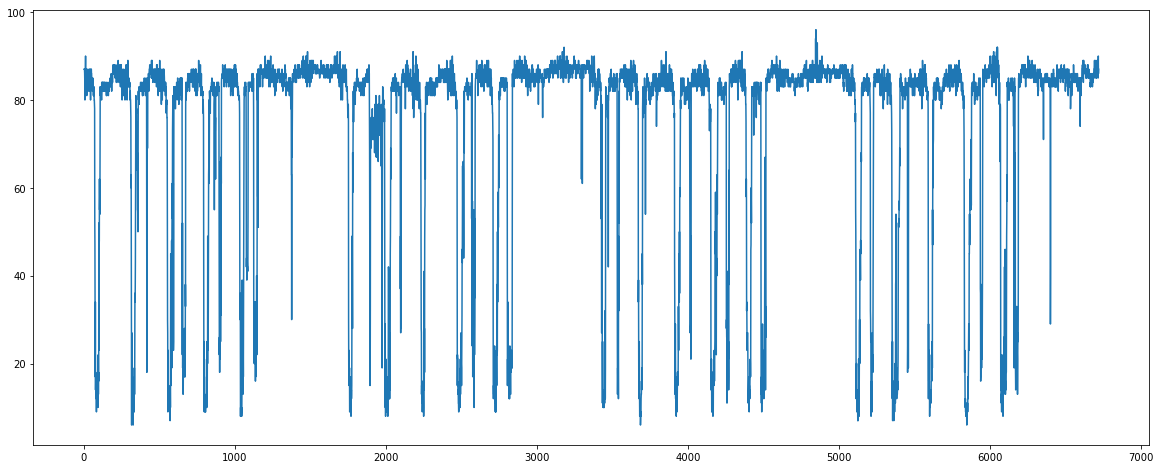

In [4]:
# On visualise notre serie temporelle dans son ensemble
plt.rcParams["figure.figsize"] = [20,8]
plt.plot(speed)

Moyenne mobile :

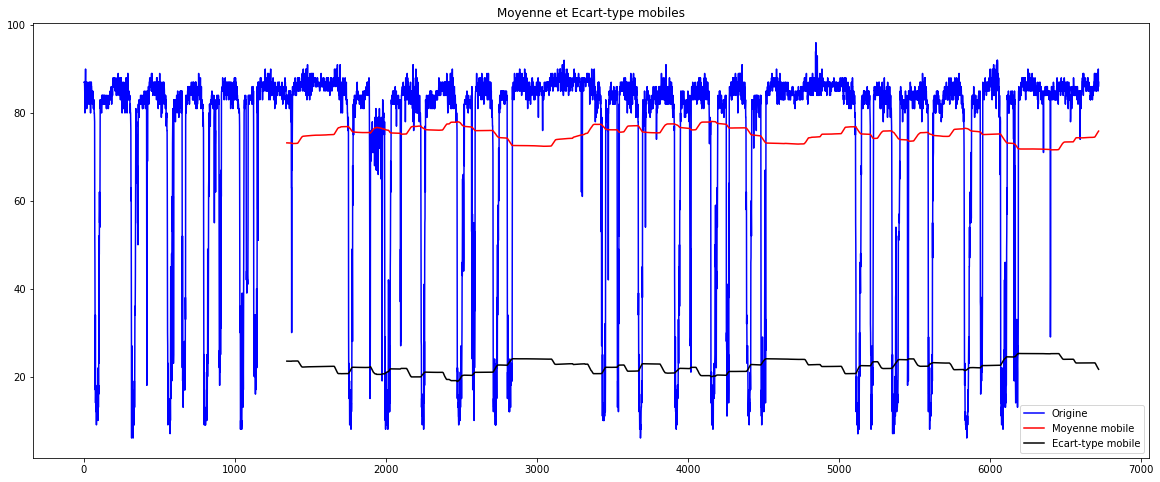

In [6]:
rolling_mean = speed.rolling(window = int(len(speed)/5)).mean()
rolling_std = speed.rolling(window = int(len(speed)/5)).std()
plt.plot(speed, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

Test de Dickey-Fuller augmenté :

In [7]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(speed)

1. ADF :  -13.4278447941662
2. P-Value :  4.0686367553305954e-25
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 6704
5. Critical Values :
	 1% :  -3.431325806331395
	 5% :  -2.8619712250080758
	 10% :  -2.5669995374408683


la P-value est inférieur à 0.05 donc nous pouvons considérer que les valeurs sont stationnaires : 

## Modèle ARIMA

### Echantillonage des données

In [105]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [106]:
Df = df_lapil42['speed']
Df.index = df_lapil42['date']

In [107]:
n_total = len(df_lapil42)
n_test = 1500 #arbitrary
n_train = n_total - n_test

In [108]:
X_train, X_valid = split_vals(Df, n_train)

In [109]:
y = df_lapil42['speed'].apply(lambda x : congestion(x))
y_train, y_valid = split_vals(y, n_train)

In [110]:
X_train

date
2019-09-23 00:00:00    87.0
2019-09-23 00:06:00    87.0
2019-09-23 00:12:00    87.0
2019-09-23 00:18:00    87.0
2019-09-23 00:24:00    86.0
                       ... 
2019-10-14 17:30:00    16.0
2019-10-14 17:36:00     9.0
2019-10-14 17:42:00    10.0
2019-10-14 17:48:00     9.0
2019-10-14 17:54:00    18.0
Name: speed, Length: 5220, dtype: float64

### Modèle

In [47]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(X_train,order=(1,0,5))
model=model.fit()
model.summary()

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  speed   No. Observations:                 5220
Model:                     ARMA(1, 5)   Log Likelihood              -17061.517
Method:                       css-mle   S.D. of innovations              6.355
Date:                Tue, 08 Jun 2021   AIC                          34139.034
Time:                        10:02:15   BIC                          34191.516
Sample:                    09-23-2019   HQIC                         34157.388
                         - 10-14-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          75.0443      2.114     35.503      0.000      70.901      79.187
ar.L1.speed     0.9569      0.005    200.072      0.000       0.948       0.966
ma.L1.speed    -0.1220      0.015     -8.365      0.000      -0.151      -0.093
ma.L2.speed     0.0384      0.014      2.669      0.008       0.010       0.067
ma.L3.speed     0.0477      0.014      3.323      0.001       0.020       0.076
ma.L4.speed     0.0202      0.014      1.469      0.142      -0.007       0.047
ma.L5.speed     0.0550      0.014      3.936      0.000       0.028       0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0450           +0.0000j            1.0450            0.0000
MA.1            1.2634           -1.0504j            1.6430           -0.1104
MA.2            1.2634           +1.0504j            1.6430            0.1104
MA.3           -1.8828           -0.0000j            1.8828           -0.5000
MA.4           -0.5057           -1.8221j            1.8910           -0.2931
MA.5           -0.5057           +1.8221j            1.8910            0.2931
-----------------------------------------------------------------------------
"""

In [65]:
pd.concat([X_train, X_valid]).to_csv('Data/csv_timeseries.csv')

In [78]:
df = pd.read_csv('Data/csv_timeseries.csv', parse_dates = ['date'])

In [79]:
X_train, X_valid = split_vals(df, n_train)

In [80]:
X_train.columns

Index(['date', 'speed'], dtype='object')

In [92]:
def congestion(x):
    if x > 80: return 0
    else: return 1

In [93]:
model.predict(X_train['date'][0]).apply(lambda x : congestion(x))

2019-09-23 00:00:00    1
2019-09-23 00:06:00    0
2019-09-23 00:12:00    0
2019-09-23 00:18:00    0
2019-09-23 00:24:00    0
                      ..
2019-10-14 17:30:00    1
2019-10-14 17:36:00    1
2019-10-14 17:42:00    1
2019-10-14 17:48:00    1
2019-10-14 17:54:00    1
Freq: 6T, Length: 5220, dtype: int64

In [101]:
from sklearn import metrics

In [102]:
def classifier_metrics (y_test, y_preds, average='weighted'):
    """Return Accuracy, Recall, Precision and F-1 score. 
    Average can take two arguments : macro or weighted """

    acc = metrics.accuracy_score(y_test, y_preds)
    rec = metrics.recall_score(y_test, y_preds, sample_weight = None)
    prc = metrics.precision_score(y_test, y_preds, sample_weight = None)
    f1  = metrics.f1_score(y_test, y_preds, sample_weight = None)

    print('Accuracy : {:.2f}%'.format(acc*100))
    print('Recall : {:.2f}%'.format(rec*100))
    print('Precision : {:.2f}%'.format(prc*100))
    print('F1-score : {:.2f}%'.format(f1*100))

In [112]:
classifier_metrics(y_train, model.predict(X_train.index[0]).apply(lambda x : congestion(x)))

Accuracy : 95.48%
Recall : 88.72%
Precision : 90.46%
F1-score : 89.59%
